# Objectives:
- Increase awareness of different types of biases that can manifest a model data
- Explore future data to proactively identify potential sources of bias before training a model
- Evaluate model performance by subgroup rather than in aggregate

# About the Dataset and Prediction Task
In this exercise, you'll work with the Adult Census Income dataset, which is commonly used in machine learning literature. This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker.

Each example in the dataset contains the following demographic data for a set of individuals who took part in the 1994 Census:

## Numeric Features:
- `age:` The age of the individual in years.
- `fnlwgt:` The number of individuals the Census Organizations believes that set of observations represents.
- `education_num:` n enumeration of the categorical representation of education. The higher the number, the higher the education that individual achieved. For example, an education_num of 11 represents Assoc_voc (associate degree at a vocational school), an education_num of 13 represents Bachelors, and an education_num of 9 represents HS-grad (high school graduate).
- `capital_gain:` Capital gain made by the individual, represented in US Dollars.
- `capital_loss:` Capital loss made by the individual, represented in US Dollars.
- `hours_per_week:` Hours worked per week.

## Catagorical Features:
- `workclass:` The individual's type of employer. Examples include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, and Never-worked.
- `education:` The highest level of education achieved for that individual.
- `marital_status:` Marital status of the individual. Examples include: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, and Married-AF-spouse.
- `occupation:` The occupation of the individual. Example include: tech-support, Craft-repair, Other-service, Sales, Exec-managerial and more.
- `relationship:` The relationship of each individual in a household. Examples include: Wife, Own-child, Husband, Not-in-family, Other-relative, and Unmarried.
- `gender:` Gender of the individual available only in binary choices: Female or Male.
- `race:` White, Asian-Pac-Islander, Amer-Indian-Eskimo, Black, and Other.
- `native_country:` Country of origin of the individual. Examples include: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, and more.

## Prediction Task:
To determine whether a person makes over $50,000$ US Dollar a year.

## Label:
- `income_bracket:` Whether the person makes more than $50,000$ US Dollars annually.

## Notes for Data Collection:
- `age` is 16 years or older.
- The adjusted gross income (used to calculate `income_bracket`) is greater than $100$ USD annually.
- `fnlwgt` is greater than 0.
- `hours_per_week` is greater than 0.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

import ipywidgets as widgets
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

2022-11-01 14:12:34.115855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 14:12:34.189739: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-01 14:12:34.192980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 14:12:34.192987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Load the Adult Dataset

In [6]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
          "marital_status", "occupation", "relationship", "race", "gender",
          "capital_gain", "capital_loss", "hours_per_week", "native_country",
          "income_bracket"]

train_csv = tf.keras.utils.get_file('adult.data',
                                   'https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv')
test_csv = tf.keras.utils.get_file('adult.test',
                                  'https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*',
                      engine='python', na_values='?')
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*', skiprows=[0],
                      engine='python', na_values='?')

# Strip trailing periods mistakenly included only in UCI test dataset.
test_df['income_bracket'] = test_df.income_bracket.str.rstrip('.')

## Analyzing the Dataset with Facets

Some important questions to investigate when auditing a dataset for fairness:
- Are there `missing feature values` or `large number of observations`?
- Are there features that are missing that might affect the other features?
- Are there any `unexpected feature values`?
- What kind of `data skew` is observed?

## Visualize the data in facets

In [7]:
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

#### Are there missing feature values for a large number of observations?
`workclass` and `occupation` features contain missing values.
#### Are there features that are missing that might affect other features?
NO
#### Are there any unexpected feature values?
For `hours_per_week` we can see that the minimum is 1,which might be a bit surprising, given that most jobs typically require multiple hours of work per week. For `capital_gain` and `capital_loss`, we can see that over 90% of values are 0. Given that capital gains/losses are only registered by individuals who make investments, it's certainly plausible that less than 10% of examples would have nonzero values for these feature, but we may want to take a closer look to verify the values for these features are valid.
#### What signs of data skew do you see?
Over two-thirds (approximately 67%) of examples represent males. This strongly suggests data skew, as we would expect the breakdown between genders to be closer to 50/50.

## Set the Number of Data Points to Visualize in Facets Dive

In [15]:
SAMPLE_SIZE = 5000 #@param

train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

1. In the data set, higher education levels generally tend to correlate with a higher `income bracket`. An income level of greater than $50,000$ US Dollar is more heavily represented in examples where `education` level is Bachelor's degree or higher.

2. In most `marital-status` categories, the distribution of male vs. female values is close to 1:1. The one notable exception is "married-civ-spouse", where male outnumbers female by more than 5:1. Given that we already discovered in `Task-1` that there is a disproportionately high representation of men in the data set, we can now infer that it's married women specifically that are underrepresented in the data.

In [21]:
feature = str(input()) #@param ["", "hours_per_week", "fnlwgt", "gender", "capital_gain / capital_loss", "age"] {allow-input: false}


if feature == "hours_per_week":
    print(
'''It does seem a little strange to see 'hours_per_week' max out at 99 hours,
which could lead to data misrepresentation. One way to address this is by
representing 'hours_per_week' as a binary "working 40 hours/not working 40
hours" feature. Also keep in mind that data was extracted based on work hours
being greater than 0. In other words, this feature representation exclude a
subpopulation of the US that is not working. This could skew the outcomes of the
model.''')
if feature == "fnlwgt":
    print(
"""'fnlwgt' represents the weight of the observations. After fitting the model
to this data set, if certain group of individuals end up performing poorly 
compared to other groups, then we could explore ways of reweighting each data 
point using this feature.""")
if feature == "gender":
    print(
"""Looking at the ratio between men and women shows how disproportionate the data
is compared to the real world where the ratio (at least in the US) is closer to
1:1. This could pose a huge probem in performance across gender. Considerable
measures may need to be taken to upsample the underrepresented group (in this
case, women).""")
if feature == "capital_gain" or "capital_loss":
    print(
"""As alluded to in Task #1, both 'capital_gain' and 'capital_loss' could be 
indicative of income status as only individuals who make investments register 
their capital gains and losses. The caveat is that over 90% of the values in 
both 'capital_gain' and 'capital_loss' are 0, and it's not entirely clear from 
the description of the data set why that is the case. That is, we don't know 
whether we should interpret all these 0s as "no investment gain/loss or "
investment gain/loss is unknown." Lack of context is always a flag for concern, 
and one that could trigger fairness-related issues later on. For now, we are 
going to omit these features from the model, but you are more than welcome to 
experiment with them if you come up with an idea on how capital gains and 
losses should be handled.""")
if feature == "age":
    print(
'''"age" has a lot of variance, so it might benefit from bucketing to learn
fine-grained correlations between income and age, as well as to prevent
overfitting.''')

capital_loss
As alluded to in Task #1, both 'capital_gain' and 'capital_loss' could be 
indicative of income status as only individuals who make investments register 
their capital gains and losses. The caveat is that over 90% of the values in 
both 'capital_gain' and 'capital_loss' are 0, and it's not entirely clear from 
the description of the data set why that is the case. That is, we don't know 
whether we should interpret all these 0s as "no investment gain/loss or "
investment gain/loss is unknown." Lack of context is always a flag for concern, 
and one that could trigger fairness-related issues later on. For now, we are 
going to omit these features from the model, but you are more than welcome to 
experiment with them if you come up with an idea on how capital gains and 
losses should be handled.


## Convert Adult Dataset into Tensors

In [22]:
def pandas_to_numpy(data):
    '''Convert a pandas DataFrame into a Numpy Array'''
    #empty row
    data = data.dropna(how="any", axis=0)
    
    #seperate DataFrame into two Numpy Arrays
    labels = np.array(data['income_bracket'] == ">50k")
    features = data.drop('income_bracket', axis=1)
    features = {name:np.array(value) for name, value in features.items()}
    
    return features, labels

## Create catagorical Feature Columns

In [25]:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

gender = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", ["Female", "Male"])
race = tf.feature_column.categorical_column_with_vocabulary_list(
    "race", [
        "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"
    ])
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", [
        "Married-civ-spouse", "Divorced", "Married-spouse-absent",
        "Never-married", "Separated", "Married-AF-spouse", "Widowed"
    ])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", [
        "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
        "Other-relative"
    ])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", [
        "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
        "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"
    ])

## Create Numeric Feature Column

In [26]:
age = tf.feature_column.numeric_column("age")
fnlwgt = tf.feature_column.numeric_column("fnlwgt")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

### Make age a Catagorical Feature
Bucketing (also known as binning) this feature, grouping together similar ages into different groups. This might help the model generalize better across age. 

In [27]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

## Consider Key Subgroups
When performing feature engineering, it's important to keep in mind that you may be working with data drawn from individuals belonging to subgroups, for which you'll want to evaluate model performance separately.

NOTE: In this context, a subgroup is defined as a group of individuals who share a given characteristic—such as race, gender, or sexual orientation—that merits special consideration when evaluating a model with fairness in mind.

When we want our models to mitigate, or leverage, the learned signal of a characteristic pertaining to a subgroup, we will want to use different kinds of tools and techniques—most of which are still actively being researched and developed. You can find a list of related research work and techniques at our Responsible AI Practices page.

## Define the Model Features
We'll consider `gender` a subgroup and save it in a seperate `subgroup_variables` list, so we can add special handling for it as needed

In [29]:
variables = [native_country, education, occupation, workclass,
            relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

## Train a Deep Neural Net Model on Adult Dataset
We have to convert our high-dimensional categorical features into a low-dimensional and dense real-valued vector, which we call an embedding vector. Luckily, indicator_column (think of it as one-hot encoding) and embedding_column (that converts sparse features into dense features) helps us streamline the process.<br><br>

Based on our analysis of the data set from previous FairAware Tasks, we are going to move forward with the following features:
- workclass
- education
- age_buckets
- relationship
- native_country
- occupation


In [30]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
]

## Define Deep Neural Net Model

In [32]:
HIDDEN_UNITS_LAYER_01 = 128
HIDDEN_UNITS_LAYER_02 = 64
LEARNING_RATE = 0.1
L1_REGULARIZATION_STRENGTH = 0.001
L2_REGULARIZATION_STRENGTH = 0.001

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)

METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
    layers.DenseFeatures(deep_columns),
    layers.Dense(
        HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
    layers.Dense(
        HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
    layers.Dense(
        1, activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=METRICS)

## Fit Deep Neural Net Model to the Adult Training Dataset


In [50]:
EPOCHS = 100
BATCH_SIZE = 500

features, labels = pandas_to_numpy(train_df)
model.fit(x=features, y=labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0260 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0241 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0228 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0218 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0209 

61/61 [==============================] - 0s 2ms/step - loss: 0.0116 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 37/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0115 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 38/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0114 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 39/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0113 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 40/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0112 - tp: 0.

61/61 [==============================] - 0s 2ms/step - loss: 0.0090 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 72/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0089 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 73/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0089 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 74/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0088 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30162.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Epoch 75/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0088 - tp: 0.

## Evaluate Deep Neural Net Performance

In [51]:
features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels)

471/471 [==============================] - 1s 1ms/step - loss: 0.0078 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 15060.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00


[0.0077767460606992245, 0.0, 0.0, 15060.0, 0.0, 1.0, 0.0, 0.0, 0.0]

## Evaluating for Fairness Using a Confusion Matrix
Our confusion matrix represents four possible states:
- `true positive:` Model predictse `>50K`, and that is ground truth
- `true negative:` Model predictse `<50K`, and that is ground truth
- `false positive:` Model predicts `>50K`, and that contradicts reality
- `false negative:` Model predicts `<50K`, and that contradicts reality

## Plot the Confusion Matrix
1. Define a function that will help us visualize the heatmap
2. Select which subgroup we're interested in, then pass that subgroup selection into `tf.keras.Model.predict()` for evaluation.

## Define Function to Visualize Binary Confusion Matrix

In [52]:
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
    
    df_cm = pd.DataFrame(
    confusion_matrix, index=class_names, columns=class_names, 
    )
    rcParams.update({
        'font.family':'sans-serif',
        'font.sans-serif':['Liberation Sans'],
    })
        
    sns.set_context("notebook", font_scale=1.25)

    fig = plt.figure(figsize=figsize)

    plt.title('Confusion Matrix for Performance Across ' + subgroup)


    strings = np.asarray([['True Positives', 'False Negatives'],
                    ['False Positives', 'True Negatives']])
    labels = (np.asarray(
        ["{0:g}\n{1}".format(value, string) for string, value in zip(
        strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
                          linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('References')
    plt.xlabel('Predictions')
    return fig

## Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup

,ACCURACY,PRECISION,RECALL,AUC
Female,1.0000,0.0000,0.0000,0.0000


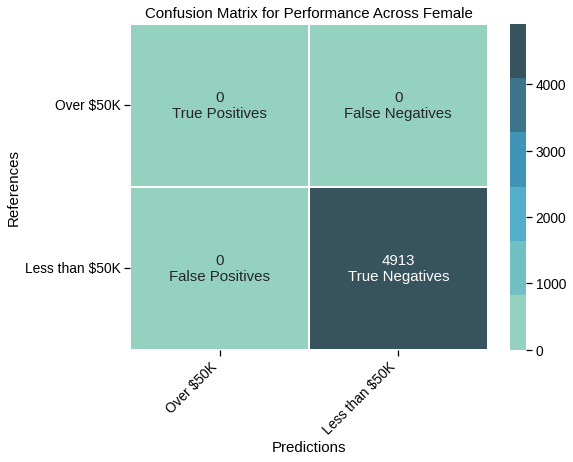

In [54]:
CATEGORY  =  "gender" 
SUBGROUP =  "Female" 

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

#given define subgroup, generate predictions and obtain its corresponding ground truth
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df